# Постановка задачи

### Задача

- Парсинг данных по книгам с сайта 'https://www.litres.ru/popular/' и построение модели пресказания потенциального рейтинга книги по ее текстовому описанию

### Описание данных

**Источник данных:** https://www.litres.ru/popular/

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests     
import numpy as np   
import pandas as pd  
import time          

In [3]:
from fake_useragent import UserAgent

In [4]:
from bs4 import BeautifulSoup

In [5]:
from fake_useragent import UserAgent

# 1. Парсинг

## 1.1 Проверка доступа к сайту

In [6]:
page_link = 'https://www.litres.ru/popular/'

response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
response

<Response [200]>

In [7]:
response.request.headers

{'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}

Посмотрим адекватно ли выгрузилось содержимое

In [8]:
html = response.content
soup = BeautifulSoup(html, 'html.parser')                        
print(soup.prettify()[:1000])

<!DOCTYPE html>
<html lang="ru">
 <script>
  if(typeof window.Intl==='undefined'||typeof window.Intl.DateTimeFormat==='undefined'||typeof window.MutationObserver==='undefined'||typeof window.IntersectionObserver==='undefined'||typeof window.ResizeObserver==='undefined'){document.write('<script src="https://polyfill.io/v3/polyfill.min.js?features=Intl.DateTimeFormat%2CMutationObserver%2CIntersectionObserver%2CResizeObserver"></scr'+'ipt>')}
 </script>
 <head>
  <meta charset="utf-8"/>
  <link href="https://www.litres.ru/static/litres/favicon.svg" rel="shortcut icon" type="image/svg+xml"/>
  <link href="https://www.litres.ru/static/litres/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="/rss/" rel="alternate" title="Новые книги на Литрес" type="application/rss+xml"/>
  <link href="https://www.litres.ru/static/litres/i/social/seo/icon_114x114.png?caf381" rel="apple-touch-icon"/>
  <link href="https://www.litres.ru/static/litres/inc/seo/yandex-tableau-manifest.json" rel

**Заключение**

- Доступ к странице есть;
- Данные выгрузились адекватно

## 2.1 Описание парсера

Сформируем скрипт выгрузки ссылок на книги со страницы

In [9]:
book_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('data-testid') == "art__title")
book_links = [link.attrs['href'] for link in book_links]

Проверим адекватна ли выгрузка

In [10]:
print(f'Всего ссылок выгружено: {len(book_links)}')
book_links[:10]

Всего ссылок выгружено: 36


['/book/tatyana-muzhickaya/teoriya-neveroyatnosti-kak-mechtat-chtoby-sbyvalos-kak-27304463/',
 '/book/luk-boden/hooponopono-drevniy-gavayskiy-metod-ispolneniya-zhelaniy-48428074/',
 '/book/ekaterina-kablukova/spasti-chudovische-70338325/?erid=LjN8K8pDB&source=art&adv_art_id=252&campaign_id=1709&promo_art_position=3&platform=web',
 '/audiobook/patrik-king/chitayte-ludey-kak-knigu-kak-analizirovat-ponimat-i-predskazyv-65834170/',
 '/book/sergey-lukyanenko/forsayt-70358980/',
 '/book/meri-li/tuman-polnoe-izdanie-70313815/',
 '/book/patrik-king/perestante-ugozhdat-ludyam-budte-assertivnym-perestante-zaboti-68002241/',
 '/book/erofey-trofimov/shatun-shag-v-neizvestnost-70336498/',
 '/book/anne-dar/rodnaya-krov-67066479/',
 '/book/mayk-omer/vnutri-ubiycy-47453330/']

Отлично, ссылки выгружаются. 
Оформим в виде функции

In [11]:
def getPageLinks(page_number):
    """
        Возвращает список ссылок на книги

        page_number: int/string
            номер страницы для парсинга

    """
    # составляем ссылку на страницу поиска
    page_link = 'https://www.litres.ru/popular/?page={}'.format(page_number)

    # запрашиваем данные по ней
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})

    if not response.ok:
        # если сервер нам отказал, вернем пустой лист для текущей страницы
        return []

    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')

    # наконец, ищем ссылки на мемы и очищаем их от ненужных тэгов
    book_links = soup.findAll(lambda tag: tag.name == 'a' and tag.get('data-testid') == "art__title")
    book_links = ['https://www.litres.ru' + link.attrs['href'] for link in book_links]

    return book_links

Протестируем функцию и убедимся, что всё хорошо

In [13]:
book_links = getPageLinks(1)
book_links[:2]

['https://www.litres.ru/book/tatyana-muzhickaya/teoriya-neveroyatnosti-kak-mechtat-chtoby-sbyvalos-kak-27304463/',
 'https://www.litres.ru/book/luk-boden/hooponopono-drevniy-gavayskiy-metod-ispolneniya-zhelaniy-48428074/']

Отлично, функция работает

Теперь напишем функцию выгрузки информации о книге

In [14]:
def get_book_data(link):
    """
        Возвращает очищенное число просмотров/коментариев/...

        soup: объект bs4.BeautifulSoup
            суп текущей страницы

    """
    obj_dict = dict()
    
    # составляем ссылку на страницу поиска
    page_link = link

    # запрашиваем данные по ней
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})

    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')
    
    try:
        obj = soup.find(lambda tag: tag.name == 'h1' and tag.get('itemprop') == "name")
        obj_dict["Наименование"] = obj.text
    except:
        obj_dict["Наименование"]=None
        
    try:
        obj = soup.find(lambda tag: tag.name == 'div' and tag.get('data-testid') == "book-short-description__wrapper")
        obj = obj.find(lambda tag: tag.name == 'div').text
        obj = str(obj).replace('\n', ' ')
        obj_dict["Краткое описание"] = obj
    except:
        obj_dict["Краткое описание"]=None   
     
    try:
        obj = soup.find(lambda tag: tag.name == 'meta' and tag.get('itemprop') == "ratingValue")
        obj_dict["Рейтинг"] = obj.attrs['content']
    except:
        obj_dict["Рейтинг"] = None
        
    try:
        obj = soup.find(lambda tag: tag.name == 'meta' and tag.get('itemprop') == "ratingCount")
        obj_dict["Количество оценок"] = obj.attrs['content']
    except:
        obj_dict["Количество оценок"] = None
        
    try:
        obj = soup.find(lambda tag: tag.name == 'div' and tag.get('data-testid') == "book-factoids__reviews")
        obj = obj.find(lambda tag: tag.name == 'span').text
        obj_dict["Количество отзывов"] = obj
    except:
        obj_dict["Количество отзывов"] = None
        
    try:
        obj = soup.find(lambda tag: tag.name == 'div' and tag.get('data-analytics-id') == "book-characteristics")
        obj = obj.findAll(lambda tag: tag.name == 'div' and tag.get('class') == ["CharacteristicsBlock-module__characteristic_2SKY6"])
        obj = [row for row in obj if 'Дата выхода на Литрес' in row.text][0]
        obj_dict["Дата публикации"] = obj.find(lambda tag: tag.name=='span' and 'Дата выхода на Литрес' not in tag.text).text
    except:
        obj_dict["Дата публикации"] = None
        
        
    obj_dict['page_link'] = link

    return obj_dict

Проверим работоспособность функции

In [15]:
book_data = get_book_data('https://www.litres.ru/audiobook/patrik-king/chitayte-ludey-kak-knigu-kak-analizirovat-ponimat-i-predskazyv-65834170/')
book_data

{'Наименование': 'Читайте людей как книгу. Как анализировать, понимать и предсказывать эмоции, мысли, намерения и поведение людей',
 'Краткое описание': 'В этой книге Патрика Кинга, автора мировых бестселлеров в области навыков социальной коммуникации, рассмотрены способы, с помощью которых можно развить умение «читать» и анализировать людей, их характер, поведение, мотивацию, невысказанные намерения. Этот навык бесценен в социуме. Задача автора – научить вас получать качественную, полезную, объективную информацию о людях во время первой же встречи, чтобы вы могли выстроить модель их мыслей, ощущений и действий в контексте ситуации. Читая эту книгу, вы узнаете, как определить, что вас обманывают или пытаются вами манипулировать, как выносить суждения о личностных характеристиках и ценностях людей, наблюдая за их речью, выражениями лиц, языком тела, и даже одеждой. Кроме того, знание, как «читать» людей, усилит вашу способность к состраданию, поможет стать лучшими родителями или партнер

Отлично, данные получены. Теперь оформим в виде Pandas DataFrame

In [16]:
final_df = pd.DataFrame(columns=['Наименование',  'Краткое описание', 'Рейтинг', 'Количество оценок', 'Дата публикации',
                                 'Количество отзывов', 'page_link'])

final_df = final_df.append(book_data, ignore_index=True).dropna(axis = 1)

In [17]:
final_df

,Наименование,Краткое описание,Рейтинг,Количество оценок,Дата публикации,Количество отзывов,page_link
0,"Читайте людей как книгу. Как анализировать, по...","В этой книге Патрика Кинга, автора мировых бес...",4.2,457,15 июля 2021,49,https://www.litres.ru/audiobook/patrik-king/ch...


Теперь выгрузим интересующую нас информацию о книгах:
   - Выгрузку будем производить с 1 по 40 страницы;
   - Каждую страницу будем сохранять в отдельном pandas.Dataframe на ПК в формате .pkl на случай обрыва связи.

In [ ]:
from tqdm import tqdm_notebook

for page_number in tqdm_notebook(range(1, 41), desc='Pages'):
    final_df = pd.DataFrame(columns=['Наименование',  'Краткое описание', 'Рейтинг', 'Количество оценок', 'Дата публикации',
                                 'Количество отзывов', 'page_link'])
    # Выгружаем все ссылки на книги со страницы
    book_links = getPageLinks(page_number)
    for book_links in tqdm_notebook(book_links, desc='Books', leave=False):
        # Делаем три попытки выгрузить данные.
        for i in range(3):
            try:
    
                data_row = get_book_data(book_links)
                final_df = final_df.append(data_row, ignore_index=True)
                
                # если всё получилось - выходим из внутреннего цикла
                break
            except:
                # Иначе, пробуем еще несколько раз, пока не закончатся попытки
                print('AHTUNG! parsing once again:', book_links)
                continue
            time.sleep(0.5)
    final_df.to_pickle(f'../data/parsing/df_page_{page_number}')

# 2. EDA

## 2.1 Загрузка данных

Проверим данные, которые мы спарсили

In [18]:
df=pd.DataFrame()
for page in range(41):
    df = pd.concat([df, pd.read_pickle(f'../data/parsing/df_page_{page}')], ignore_index=True)

In [21]:
df.head()

,Наименование,Краткое описание,Рейтинг,Количество оценок,Дата публикации,Количество отзывов,page_link
0,"Теория невероятности. Как мечтать, чтобы сбыва...","Никакой магии. Только здравый смысл, психологи...",4.8,1541,16 февраля 2019,269,https://www.litres.ru/book/tatyana-muzhickaya/...
1,"Читайте людей как книгу. Как анализировать, по...","В этой книге Патрика Кинга, автора мировых бес...",4.2,456,15 июля 2021,49,https://www.litres.ru/audiobook/patrik-king/ch...
2,Спасти чудовище,"Нищая швея и граф, чье лицо изуродовано войной...",4.9,466,14 февраля 2024,112,https://www.litres.ru/book/ekaterina-kablukova...
3,Форсайт,"Людям порой снится прошлое. Иногда хорошее, ин...",4.5,165,21 февраля 2024,23,https://www.litres.ru/book/sergey-lukyanenko/f...
4,Перестаньте угождать людям. Будьте ассертивным...,Угодничество не зря называют болезнью. Оно мож...,4.3,160,08 сентября 2022,32,https://www.litres.ru/book/patrik-king/peresta...


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Наименование        1440 non-null   object
 1   Краткое описание    1440 non-null   object
 2   Рейтинг             1440 non-null   object
 3   Количество оценок   1440 non-null   object
 4   Дата публикации     1425 non-null   object
 5   Количество отзывов  1440 non-null   object
 6   page_link           1440 non-null   object
dtypes: object(7)
memory usage: 78.9+ KB


**Заключение**

- Отлично, данные выгрузить удалось
- Выгружено 1440 шт. записей

## 2.2 Типы данных

Посмотрим на типы выгруженных данных

In [22]:
def display_dtypes(df):
    df_local = df
    df_tmp = df_local#[[i for i in df_local.columns if 'datetime' in i]]

    # Обзор намеков на типы признаков
    unique_values = df_tmp.nunique().sort_values(ascending=False)
    unique_values = pd.DataFrame(unique_values, columns = ['Колич. уник. значений'])

    # Довать процентовку
    unique_values['Доля в %'] = (unique_values['Колич. уник. значений']/df_tmp.shape[0])*100
    unique_values = pd.concat([unique_values, pd.DataFrame(df_tmp.dtypes, columns=['dtype'])], axis=1) 
    display(unique_values)
    
display_dtypes(df)

,Колич. уник. значений,Доля в %,dtype
page_link,1410,97.916667,object
Краткое описание,1385,96.180556,object
Наименование,1218,84.583333,object
Количество оценок,953,66.180556,object
Дата публикации,940,65.277778,object
Количество отзывов,366,25.416667,object
Рейтинг,24,1.666667,object


**Заключение**

- **'Количество оценок'**, **'Количество отзывов'**, **'Рейтинг'** имеют тип object, но являются числами;
- Колич. уникальных значений признаков **'Краткое описание'** и **'Наименование'** намекает на наличие пропусков или/и дубликатов
- **Дата публикации** должна быть date_time

## 2.3 Проверка наличия дыр в данных

,% miss,cnt
Наименование,0,0
Краткое описание,0,0
Рейтинг,0,0
Количество оценок,0,0
Количество отзывов,0,0
page_link,0,0
Дата публикации,1,15


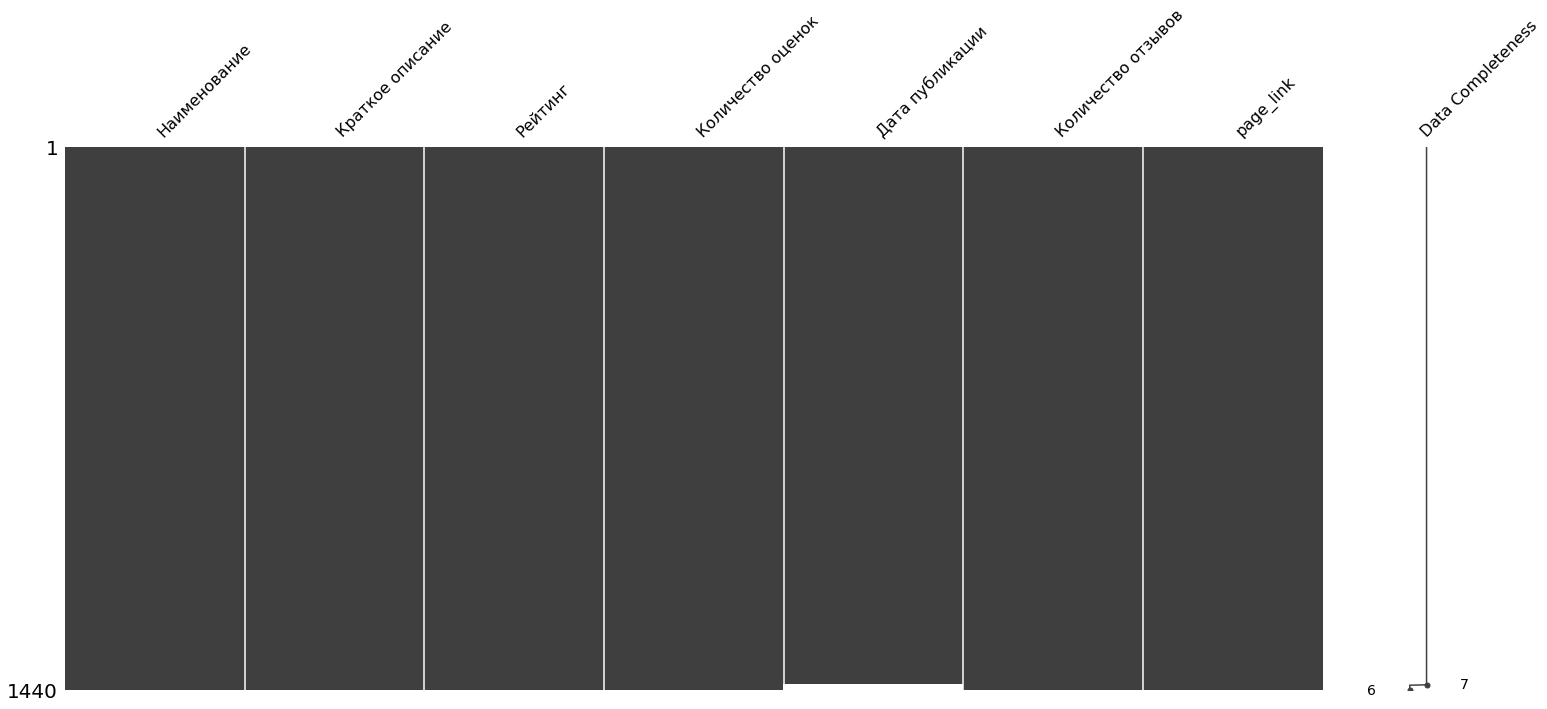

In [23]:
import missingno as msno


# Процентный список пропущенных значений
def scan_miss_val(df: pd.DataFrame) -> pd.DataFrame:
    '''
    :param df:
    :return: На выходе столбец значений =(% NAN) в признаке.
    '''
    # ___init___
    miss_val_df = pd.DataFrame()
    NA_present = 0

    # Обработка каждого столбца отдельно
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        temp = pd.DataFrame([round(pct_missing * 100)], columns=['% miss'], index=[col])
        temp['cnt'] = df[col].isnull().sum()

        miss_val_df = pd.concat([miss_val_df, temp], axis=0)

        if (pct_missing != 0) & (NA_present == 0):
            NA_present = NA_present + 1

    # Построение Тепловой карты пропущенных значений
    if NA_present != 0:
        msno.matrix(df, labels=True, sort="descending")

    return miss_val_df.sort_values(by='% miss')

scan_miss_val(df)

**Заключение**

- Имеются пропуски в признаке **Дата публикации**

## 2.4 Наличие дубликатов

Учитывая постановку задачи, проверим наличие дубликатов по признаку **'Краткое описание'**

In [24]:
# Сканирование на наличие дубликатов
columns_to_concider = ['Краткое описание']
df_duplicated = df.duplicated(subset=columns_to_concider)

n_duplicates = df_duplicated.sum()
print('Number of duplicates = ', n_duplicates)

Number of duplicates =  55


**Заключение**

- Имеются дубликаты по признакам **'Краткое описание'**,. Вероятно вызваны разным форматом книг

## 2.5 Преобразование данных по результатам EDA

### 2.5.1 Удаление пропусков и дубликатов

In [25]:
df.drop_duplicates(subset = ['Краткое описание'], inplace=True)

In [26]:
# Сканирование на наличие дубликатов
columns_to_concider = ['Краткое описание']
df_duplicated = df.duplicated(subset=columns_to_concider)

n_duplicates = df_duplicated.sum()
print('Number of duplicates = ', n_duplicates)

Number of duplicates =  0


In [27]:
df.dropna(subset=['Дата публикации'], inplace=True)

In [28]:
scan_miss_val(df)

,% miss,cnt
Наименование,0,0
Краткое описание,0,0
Рейтинг,0,0
Количество оценок,0,0
Дата публикации,0,0
Количество отзывов,0,0
page_link,0,0


In [29]:
df.reset_index(drop=True, inplace=True)

### 2.5.2 Преобразование типов

Приведем признаки **Количество отзывов**, **Рейтинг**, **Количество оценок** к числовому типу

In [30]:
def str_to_digit(x):
    
    if ((str(x).find('K')) or (str(x).find(','))) == -1:
        
        try:
            out = float(x)
        except:
            out = x
    else:
        try:
            out = str(x)
            for symbol in ',K':
                out = out.replace(symbol, '')
            out = float(out)*1000
        except:
            out = x
            
    return out

In [31]:
def transform_to_digit (df: pd.DataFrame, columns: list):
    df_temp = df.copy()
    for col in columns:
        df_temp[col] = df_temp[col].apply(lambda x: str_to_digit(x))
        condition = df_temp['Количество отзывов'].apply(lambda x: True if type(x) is not float else False)
        print(f'Обработка признака: {col}')
        print(f'Пропущено значений: {df_temp[condition].shape[0]}')
        print('\n')
    
    return df_temp

In [32]:
df_temp = transform_to_digit (df, columns = ['Количество отзывов', 'Рейтинг', 'Количество оценок'])
df_temp.info()

Обработка признака: Количество отзывов
Пропущено значений: 0


Обработка признака: Рейтинг
Пропущено значений: 0


Обработка признака: Количество оценок
Пропущено значений: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373 entries, 0 to 1372
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Наименование        1373 non-null   object 
 1   Краткое описание    1373 non-null   object 
 2   Рейтинг             1373 non-null   float64
 3   Количество оценок   1373 non-null   float64
 4   Дата публикации     1373 non-null   object 
 5   Количество отзывов  1373 non-null   float64
 6   page_link           1373 non-null   object 
dtypes: float64(3), object(4)
memory usage: 75.2+ KB


In [33]:
df = df_temp.copy()
df.reset_index(drop=True, inplace=True)

Удалим записи, у которых нет оценок

In [34]:
cond = df['Количество оценок'] < 1
df.drop(index=df[cond].index, inplace=True)

Теперь преобразуем признак **Дата публикации** к date_time

In [35]:
def to_date_time(x):
    try:
        dictionary = {'января': '01',
                      'февраля': '02',
                      'марта': '03',
                      'апреля': '04',
                      'мая': '05',
                      'июня': '06',
                      'июля': '07',
                      'августа': '08',
                      'сентября': '09',
                      'октября': '10',
                      'ноября': '11',
                      'декабря': '12'}

        spisok = x.split()
        spisok[1] = spisok[1].replace(spisok[1], dictionary[spisok[1]])
        spisok = '-'.join(spisok)
        spisok = pd.to_datetime(spisok,
                   format='%d-%m-%Y')
    except:
        spisok = x
    
    return spisok

In [36]:
df['Дата публикации'] = df['Дата публикации'].apply(lambda x: to_date_time(x))

In [37]:
df['Дата публикации'].head()

0   2019-02-16
1   2021-07-15
2   2024-02-14
3   2024-02-21
4   2022-09-08
Name: Дата публикации, dtype: datetime64[ns]

**Заключение**
 - Все дубликаты удалены;
 - Удалены записи, по которым отсутствуют оценки;
 - Преобразованы типы данных для признаков **Количество отзывов**, **Рейтинг**, **Количество оценок** и **Дата публикации**

Сохраним обработанный датасет в файл

In [38]:
df.to_pickle('../data/df_prepeared.pkl')

# 3. NLP

In [7]:
%matplotlib inline
! pip install pymorphy2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import nltk   # Natural Language Toolkit

## 3.1 Загрузим данные

Загрузим наши обработанные данные

In [9]:
df = pd.read_pickle('../data/df_prepeared.pkl')
display(df.head())
display(df.info())

,Наименование,Краткое описание,Рейтинг,Количество оценок,Дата публикации,Количество отзывов,page_link
0,"Теория невероятности. Как мечтать, чтобы сбыва...","Никакой магии. Только здравый смысл, психологи...",4.8,1541.0,2019-02-16,269.0,https://www.litres.ru/book/tatyana-muzhickaya/...
1,"Читайте людей как книгу. Как анализировать, по...","В этой книге Патрика Кинга, автора мировых бес...",4.2,456.0,2021-07-15,49.0,https://www.litres.ru/audiobook/patrik-king/ch...
2,Спасти чудовище,"Нищая швея и граф, чье лицо изуродовано войной...",4.9,466.0,2024-02-14,112.0,https://www.litres.ru/book/ekaterina-kablukova...
3,Форсайт,"Людям порой снится прошлое. Иногда хорошее, ин...",4.5,165.0,2024-02-21,23.0,https://www.litres.ru/book/sergey-lukyanenko/f...
4,Перестаньте угождать людям. Будьте ассертивным...,Угодничество не зря называют болезнью. Оно мож...,4.3,160.0,2022-09-08,32.0,https://www.litres.ru/book/patrik-king/peresta...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1342 entries, 0 to 1372
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Наименование        1342 non-null   object        
 1   Краткое описание    1342 non-null   object        
 2   Рейтинг             1342 non-null   float64       
 3   Количество оценок   1342 non-null   float64       
 4   Дата публикации     1342 non-null   datetime64[ns]
 5   Количество отзывов  1342 non-null   float64       
 6   page_link           1342 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 83.9+ KB


None

Отлично данные загружены, форматы подходят к обработке

## 3.2 Шаг 1. Токенизация

In [10]:
word_tokenizer = nltk.WordPunctTokenizer()

Проведем токенизацию на содержании признака **Краткое описание** первой записи

In [11]:
df.iloc[[3]]['Краткое описание'].values[0]

'Людям порой снится прошлое. Иногда хорошее, иногда не очень… Но что делать, если тебе начинает сниться будущее? И в нем ничего хорошего нет совсем.'

Сформируем свой (дополнительный) списко стоп-слов из всех имеющихся записей

In [12]:
stop_df = pd.DataFrame()
for i in range(df.shape[0]):
    tokens = word_tokenizer.tokenize(df.iloc[[i]]['Краткое описание'].values[0])
    
    df_tokens = pd.DataFrame(tokens)
    df_tokens['len'] = df_tokens[0].apply(lambda x: len(x))
    
    
    stop_df = pd.concat([stop_df, df_tokens[df_tokens['len']<4][0]], ignore_index=True)

my_stop_w = list(stop_df[0].apply(lambda x: x.lower()))

In [13]:
display(my_stop_w[:10])
display(my_stop_w[-10:])

['.', ',', 'и', '-', 'в', '.', '–', ',', 'и', '–']

['вот', '-', 'вот', 'с', '.', ',', 'и', 'без', 'еще', '.']

## 3.3 Шаг 2. Удаляем стоп-слова

Сначала загрузим список стоп-слов из словаря

In [14]:
# загружаем список стоп-слов для русского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# примеры стоп-слов
print(len(stop_words))
print(stop_words[:10])

151
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KPS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
import re
regex = re.compile(r'[А-Яа-яA-zёЁ-]+')

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text)).lower()
    except:
        return ""

In [16]:
import re
from tqdm import tqdm_notebook
regex = re.compile(r'[А-Яа-яA-zёЁ-]+')

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text)).lower()
    except:
        return ""

# расширим список стоп-слов, словами, которые являеются стоп-словами в данной задаче
all_stop_words = stop_words + my_stop_w

def process_data(df):
    
    data = df.copy()
    texts = []
    targets = []

    # поочередно проходим по всем новостям в списке
        
    for i in tqdm_notebook(range(data.shape[0])):
        text = data.iloc[[i]]['Краткое описание'].values[0]

        text_lower = words_only(text) # оставим только слова
        tokens     = word_tokenizer.tokenize(text_lower) #разбиваем текст на слова

        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in all_stop_words and not word.isnumeric())]

        data['Краткое описание'].iloc[[i]] = data['Краткое описание'].iloc[[i]].apply(lambda x: tokens) # добавляем в предобработанный список

    return data

In [17]:
# запускаем нашу предобработку
df_tokened = process_data(df)

  0%|          | 0/1342 [00:00<?, ?it/s]

In [19]:
df_tokened

,Наименование,Краткое описание,Рейтинг,Количество оценок,Дата публикации,Количество отзывов,page_link
0,"Теория невероятности. Как мечтать, чтобы сбыва...","[никакой, магии, здравый, смысл, психология, в...",4.8,1541.0,2019-02-16,269.0,https://www.litres.ru/book/tatyana-muzhickaya/...
1,"Читайте людей как книгу. Как анализировать, по...","[книге, патрика, кинга, автора, мировых, бестс...",4.2,456.0,2021-07-15,49.0,https://www.litres.ru/audiobook/patrik-king/ch...
2,Спасти чудовище,"[нищая, швея, граф, лицо, изуродовано, войной,...",4.9,466.0,2024-02-14,112.0,https://www.litres.ru/book/ekaterina-kablukova...
3,Форсайт,"[людям, порой, снится, прошлое, хорошее, очень...",4.5,165.0,2024-02-21,23.0,https://www.litres.ru/book/sergey-lukyanenko/f...
4,Перестаньте угождать людям. Будьте ассертивным...,"[угодничество, называют, болезнью, искалечить,...",4.3,160.0,2022-09-08,32.0,https://www.litres.ru/book/patrik-king/peresta...
...,...,...,...,...,...,...,...
1368,Ящик Скиннера,"[профайлер, окончания, университета, поступает...",4.9,740.0,2023-07-13,21.0,https://www.litres.ru/book/ley-mi/yaschik-skin...
1369,Рисунок. Основы учебного академического рисунка,"[предлагаемой, книге, рассматриваются, теорети...",4.4,202.0,2017-08-23,12.0,https://www.litres.ru/book/nikolay-li-10842550...
1370,Договориться не проблема. Как добиваться своег...,"[переговорные, техники, описанные, крисом, вос...",4.7,680.0,2017-12-20,75.0,https://www.litres.ru/book/kris-voss/dogovorit...
1371,Повелитель мух,"[повелитель, подлинный, шедевр, мировой, литер...",4.7,939.0,2022-05-23,137.0,https://www.litres.ru/audiobook/uilyam-golding...


Сравним результаты до обработки и после для конкретного наблюдения:

In [20]:
print('Краткое описание до обработки:')
print('-----------------------------')
display(df['Краткое описание'][3])
print('Краткое описание после обработки:')
print('-----------------------------')
display(df_tokened['Краткое описание'][3])

Краткое описание до обработки:
-----------------------------


'Людям порой снится прошлое. Иногда хорошее, иногда не очень… Но что делать, если тебе начинает сниться будущее? И в нем ничего хорошего нет совсем.'

Краткое описание после обработки:
-----------------------------


['людям',
 'порой',
 'снится',
 'прошлое',
 'хорошее',
 'очень',
 'делать',
 'тебе',
 'начинает',
 'сниться',
 'будущее',
 'хорошего']

Видим, что:
- **Краткое описание** представлено списком слов. 
- Все слова с маленькой буквы. 
- Пунктуация и стоп-слова удалены.

## 3.4 Шаг 3 . Нормализация слов

- Существует 2 наиболее известных способа нормализации слов: **стемминг** и **лемматизация**.
- В общих чертах они похоже, но между этими методами есть различия. В зависимости от языка и задачи тот или иной метод может быть предпочтительнее.

Поэтому создадим два варианта нормализации и выберем тот, что дает наилучший результат на тесте

### 3.4.1 Стемминг

In [21]:
from nltk.stem.snowball import SnowballStemmer

In [22]:
def stemming (list_of_words):
    stemmer = SnowballStemmer("russian")
    new_list = []
    for aword in list_of_words:
        new_list.append(stemmer.stem(aword))
    text = ' '.join(new_list)
    return text

In [23]:
df_tokened['Стемминг'] = df_tokened['Краткое описание'].apply(lambda x: stemming(x))

Сравним результаты до обработки и после для конкретного наблюдения:

In [24]:
print('Краткое описание до обработки:')
print('-----------------------------')
display(df['Краткое описание'][3])
print('Краткое описание после обработки:')
print('-----------------------------')
display(df_tokened['Стемминг'][3])

Краткое описание до обработки:
-----------------------------


'Людям порой снится прошлое. Иногда хорошее, иногда не очень… Но что делать, если тебе начинает сниться будущее? И в нем ничего хорошего нет совсем.'

Краткое описание после обработки:
-----------------------------


'люд пор снит прошл хорош очен дела теб начина снит будущ хорош'

### 3.4.2 Лемматизация

In [28]:
# загружаем библиотеку для лемматизации
import pymorphy2 # Морфологический анализатор

In [29]:
morph = pymorphy2.MorphAnalyzer()
def lemmatization (list_of_words):
    new_list = []
    for aword in list_of_words:
        new_list.append(morph.parse(aword)[0].normal_form)
    text = ' '.join(new_list)
    return text

In [30]:
df_tokened['Лемматизация'] = df_tokened['Краткое описание'].apply(lambda x: lemmatization(x))

In [31]:
print('Краткое описание до обработки:')
print('-----------------------------')
display(df['Краткое описание'][3])
print('Краткое описание после Стемминга:')
print('-----------------------------')
display(df_tokened['Стемминг'][3])
print('Краткое описание после Лемматизации:')
print('-----------------------------')
display(df_tokened['Лемматизация'][3])

Краткое описание до обработки:
-----------------------------


'Людям порой снится прошлое. Иногда хорошее, иногда не очень… Но что делать, если тебе начинает сниться будущее? И в нем ничего хорошего нет совсем.'

Краткое описание после Стемминга:
-----------------------------


'люд пор снит прошл хорош очен дела теб начина снит будущ хорош'

Краткое описание после Лемматизации:
-----------------------------


'человек порой сниться прошлое хороший очень делать ты начинать сниться будущее хороший'

In [32]:
df_tokened.to_pickle('df_NLP.pkl')

# 4. Моделирование

## 4.1 Формирование целевого признака

Посмотрим на распределения имеющихся признаков, характеризующих рейтинг

<AxesSubplot:>

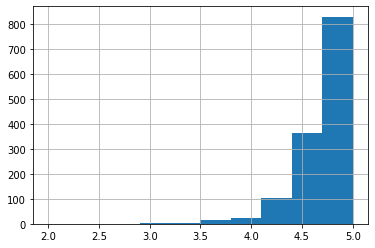

In [33]:
df_tokened['Рейтинг'].hist()

<AxesSubplot:>

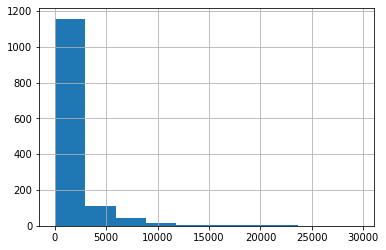

In [34]:
df_tokened['Количество оценок'].hist()

Сначала исключим те записи, по которым прошло слишком мало времени с момента публикации

In [35]:
cond = df_tokened['Дата публикации'] >= '2024'
df_tokened.drop(index=df_tokened[cond].index, inplace=True)

Построим взвешенные оценки рейтинга на основе признаков **Рейтинг** и **Количество оценок** с учетом времени, прошедшего с момента публикации

In [36]:
def get_new_raiting (df: pd.DataFrame) -> pd.DataFrame:
    df_temp = df.copy()
    
    current_date = pd.to_datetime('01-03-2024',
                   format='%d-%m-%Y')
    
    df_temp['Дата публикации'] = df_temp['Дата публикации'].apply(lambda x: abs((x- current_date).total_seconds()/100))
    df_temp['Количество оценок'] = df_temp['Количество оценок']/df_temp['Дата публикации']
    
    
    df_temp['Количество оценок'] = df_temp['Количество оценок'].apply(lambda x: np.log(x))
    df_temp['Количество оценок'] = df_temp['Количество оценок'].max()/df_temp['Количество оценок']
    df_temp['new_raiting'] = df_temp.apply(lambda x: x['Количество оценок']*x['Рейтинг'], axis=1 )
    
    return pd.concat([df, df_temp[['new_raiting']]], axis=1)

In [37]:
df = get_new_raiting(df_tokened)

Посмотрим на новый целевой признак **new_raiting**

In [38]:
df_temp = df[['Рейтинг', 'Количество оценок', 'Дата публикации', 'new_raiting']].sort_values(by='new_raiting', ascending=False)
display(df_temp.head())
display(df_temp.tail())

,Рейтинг,Количество оценок,Дата публикации,new_raiting
71,4.9,23039.0,2022-08-13,4.900000
547,4.9,2354.0,2023-12-25,4.674813
16,4.8,1892.0,2023-12-15,4.119415
183,4.9,1354.0,2023-12-20,3.911406
27,4.9,2268.0,2023-11-01,3.908047


,Рейтинг,Количество оценок,Дата публикации,new_raiting
415,3.7,10.0,2018-10-29,0.939321
1322,3.5,2.0,2023-04-26,0.905827
1058,3.3,21.0,2014-10-20,0.850503
569,3.5,4.0,2019-11-27,0.840326
1092,4.0,1.0,2015-10-09,0.826311


<AxesSubplot:>

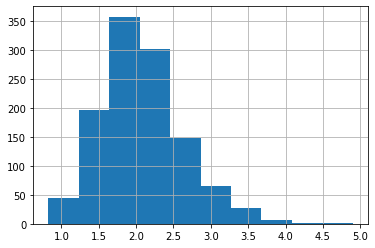

In [39]:
df['new_raiting'].hist()

Отлично, новый целевой признак сформирован

## 4.2 train_test

Разделим наш датасет на обучающую и тестовую выборку

In [43]:
#train test_split
from sklearn.model_selection import train_test_split
train_df, test_df, train_y, test_y = train_test_split(df.drop(columns=['new_raiting']), df['new_raiting'], test_size=0.2, random_state=42, stratify = df['new_raiting_cat'])

##  4.3 Векторное представление Bag of Words

Используем метод **Bag of Words** для преобразования текста в признаковое пространство для использования класических моделей ML

### 4.3.1 Стемминг

Построим пространство признаков на базе результатов номализации типа Стемминг

In [44]:
#Инициализируем векторайзер
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 100)
vectorizer.fit(list(train_df['Стемминг']))

# Топ-10 слов
vectorizer.get_feature_names_out()[:10]

array(['автор', 'аудиокниг', 'бестселлер', 'бизнес', 'больш', 'важн',
       'ваш', 'вмест', 'возможн', 'вопрос'], dtype=object)

In [45]:
# Обучаем vectorizer на train-данных и сразу преобразем их в вектора с помощью метода fit_transform
stemming_train_X = vectorizer.transform(list(train_df['Стемминг']))
stemming_train_X.todense()[:2]

matrix([[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

In [46]:
stemming_test_X = vectorizer.transform(list(test_df['Стемминг']))

### 4.3.2 Лемматизация

Построим пространство признаков на базе результатов номализации типа Лемматизация

In [47]:
#Инициализируем векторайзер
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 100)
vectorizer.fit(list(train_df['Лемматизация']))

# Топ-10 слов
vectorizer.get_feature_names_out()[:10]

array(['автор', 'аудиокнига', 'бестселлер', 'бизнес', 'быть', 'важный',
       'ваш', 'весь', 'вместе', 'война'], dtype=object)

In [48]:
# Обучаем vectorizer на train-данных и сразу преобразем их в вектора с помощью метода fit_transform
lemm_train_X = vectorizer.transform(list(train_df['Лемматизация']))
lemm_train_X.todense()[:2]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

In [49]:
lemm_test_X = vectorizer.transform(list(test_df['Лемматизация']))

### 4.3.3 Строим классификатор

In [56]:
#import алгоритма из библиотеки
from sklearn.ensemble import RandomForestRegressor

def get_fit_predict(X_train, y_train, X_test):
    # инициализируем модель
    clf = RandomForestRegressor(n_estimators = 1000)

    # обучаем ее на тренировочных данных
    clf = clf.fit(X_train, list(y_train))

    # делаем предсказание для тестовых данных
    pred = clf.predict(X_test)
    
    return pred

In [58]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### a) Стемминг

In [59]:
pred = get_fit_predict(X_train=stemming_train_X,
                       y_train=train_y,
                       X_test=stemming_train_X)
mean_absolute_percentage_error(train_y, pred)

6.948507388509009

In [62]:
pred = get_fit_predict(X_train=stemming_train_X,
                       y_train=train_y,
                       X_test=stemming_test_X)
mean_absolute_percentage_error(test_y, pred)

18.75795923457206

#### b)  Лемматизация

In [63]:
pred = get_fit_predict(X_train=lemm_train_X,
                       y_train=train_y,
                       X_test=lemm_train_X)
mean_absolute_percentage_error(train_y, pred)

6.903452979200857

In [64]:
pred = get_fit_predict(X_train=lemm_train_X,
                       y_train=train_y,
                       X_test=lemm_test_X)
mean_absolute_percentage_error(test_y, pred)

18.730132790318557

## 4.4 Векторное представление TF-IDF

Используем более сложный метод **TF-IDF** для преобразования текста в признаковое пространство для использования класических моделей ML

### 4.4.1 Стемминг

Построим пространство признаков на базе результатов номализации типа Стемминг

In [65]:
#вычисляем tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(max_features = 200, norm = None) # возмем топ 200 слов
vectorizer.fit(list(train_df['Стемминг']))

# Топ-10 слов
vectorizer.get_feature_names_out()[:10]

array(['автор', 'аудиокниг', 'бестселлер', 'бизнес', 'больш', 'будущ',
       'важн', 'ваш', 'век', 'велик'], dtype=object)

In [66]:
# Обучаем TF-IDF на train, а затем применяем к train и test
stemming_train_X = vectorizer.fit_transform(list(train_df['Стемминг']))
stemming_test_X  = vectorizer.transform(list(test_df['Стемминг']))

### 4.4.2 Лемматизация

Построим пространство признаков на базе результатов номализации типа Лемматизация

In [67]:
#вычисляем tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(max_features = 200, norm = None) # возмем топ 200 слов
vectorizer.fit(list(train_df['Лемматизация']))

# Топ-10 слов
vectorizer.get_feature_names_out()[:10]

array(['автор', 'аудиокнига', 'бестселлер', 'бизнес', 'больший',
       'будущее', 'быть', 'важный', 'ваш', 'век'], dtype=object)

In [68]:
# Обучаем TF-IDF на train, а затем применяем к train и test
lemm_train_X = vectorizer.fit_transform(list(train_df['Лемматизация']))
lemm_test_X  = vectorizer.transform(list(test_df['Лемматизация']))

### 4.4.3 Строим классификатор

#### a) Стемминг

In [69]:
pred = get_fit_predict(X_train=stemming_train_X,
                       y_train=train_y,
                       X_test=stemming_train_X)
mean_absolute_percentage_error(train_y, pred)

7.002509459444582

In [70]:
pred = get_fit_predict(X_train=stemming_train_X,
                       y_train=train_y,
                       X_test=stemming_test_X)
mean_absolute_percentage_error(test_y, pred)

18.134069803566096

#### b) Лемматизация

In [71]:
pred = get_fit_predict(X_train=lemm_train_X,
                       y_train=train_y,
                       X_test=lemm_train_X)
mean_absolute_percentage_error(train_y, pred)

6.87971207989272

In [72]:
pred = get_fit_predict(X_train=lemm_train_X,
                       y_train=train_y,
                       X_test=lemm_test_X)
mean_absolute_percentage_error(test_y, pred)

18.13038059319768

# Заключение

В рамках работы:
 - Написан Парсер, с помощью которго была выгружена информация о книгах с сайта ЛитРес. Сформирован датасет.
 - Проведен обзорные EDA с приведеним данных к нужному формату;
 - Сформирован целевой признак из разных статистик, выгруженных с сайта.
 - Произведена токенизация и сформирован расширенный список стоп-слов из всех текстовых описаний.
 - Произведены два типа нормализации для дальнейшего сравнения.
 - Использованы два метода формирования признаково пространства и проведено моделирование обучающей и тестовой выборки для разных вариантов нормализации.
 
Результаты моделирования:
 - Наилучшие результаты получили при: TF-IDF с нормализацией типа Лемматизация